In [43]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Fram Strait')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [5]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [6]:
# Get area for Davis Strait
dyA_FrS = dyA*maskW
dxA_FrS = dxA*maskS*-1

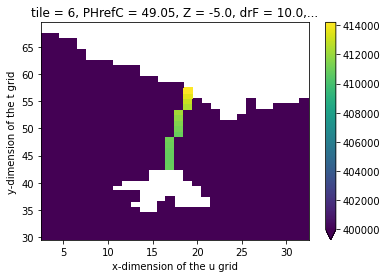

In [7]:
dyA_FrS[6,:,:,0].where(main.hFacW[0,6].values==1)[30:70,3:33].plot(vmin=4.0e5)

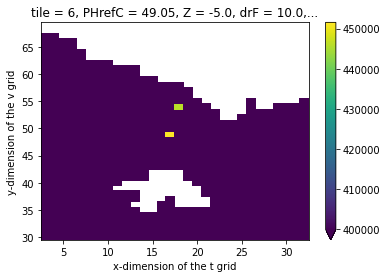

In [8]:
dxA_FrS[6,:,:,0].where(main.hFacW[0,6].values==1)[30:70,3:33].plot(vmin=4.0e5)

/usr/local/lib/python3.6/dist-packages/xarray/core/dataarray.py:1913: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return self.transpose()


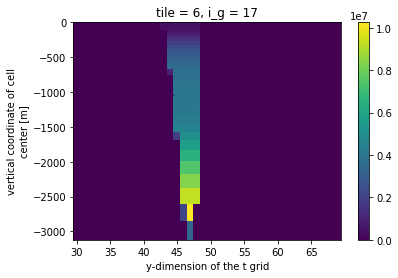

In [9]:
dyA_FrS[6,30:70,17,:].T.swap_dims({'k':'Z'})[:42].plot()

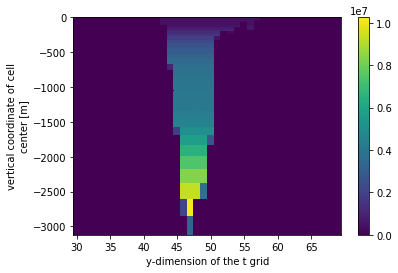

In [10]:
dyA_FrS.sum(dim=['i_g','tile'])[30:70,:42].T.swap_dims({'k':'Z'}).plot()

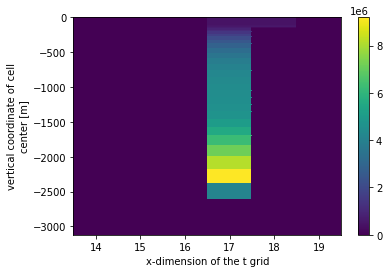

In [11]:
dxA_FrS.sum(dim=['j_g','tile'])[14:20,:42].T.swap_dims({'k':'Z'}).plot()

In [12]:
sec_area_x = dyA_FrS.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_FrS.sum(dim=['i','j_g','tile'])

In [13]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 777.0 km^2


### Volume flux

In [14]:
#u_transport = main['UVELMASS'] * main['drF'] * main['dyG']
#v_transport = main['VVELMASS'] * main['drF'] * main['dxG']

u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

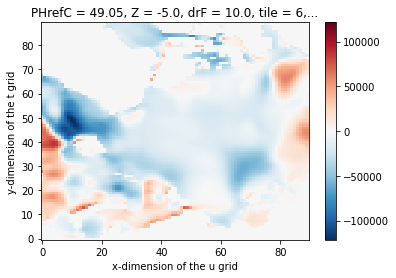

In [15]:
u_transport[:,0,6].mean('time').plot()

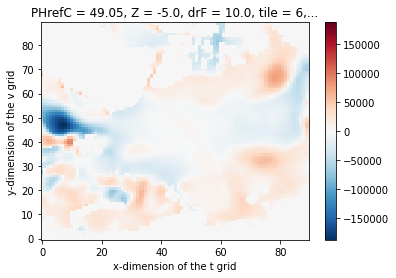

In [16]:
v_transport[:,0,6].mean('time').plot()

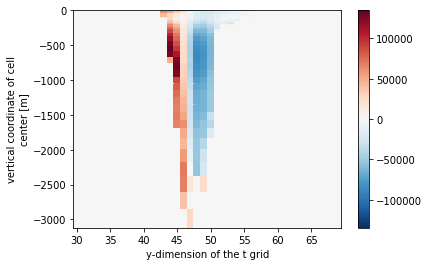

In [17]:
(u_transport * maskW).sum(dim=['i_g','tile']).mean('time')[:42,30:70].swap_dims({'k':'Z'}).plot()

In [18]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [19]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_trsp = sec_trsp.sel(time=slice('1993-01-01','2015-12-31'))

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,1),'±',np.round(2*sec_trsp.std('time').values,1),'Sv')

Vol. flux (1992-2015): -2.9 ± 2.0 Sv


### Calculate freshwater fluxes

In [20]:
# Reference salinity
#Sref = 35.0
Sref = 34.9

In [21]:
grid = ecco.get_llc_grid(main)

In [22]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [23]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

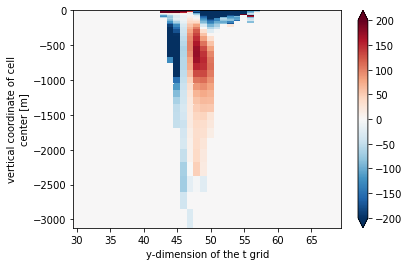

In [24]:
(ADVx_FW * maskW).sum(dim=['i_g','tile']).mean('time')[:42,30:70].swap_dims({'k':'Z'}).plot(vmin=-200)

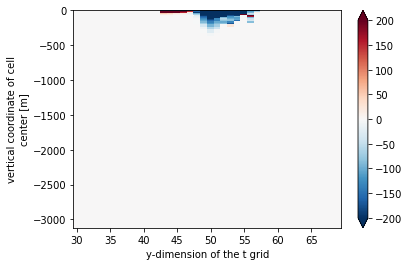

In [25]:
(ADVx_FW.where(SALT_at_u.values<=34.9)*maskW).sum(dim=['i_g','tile']).mean('time')[:42,30:70]\
            .swap_dims({'k':'Z'}).plot(vmin=-200)

In [26]:
# Full-depth integration
#sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
#sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])

# Integration from isohaline
sec_trsp_x = (ADVx_FW.where(SALT_at_u.values<=34.9) * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW.where(SALT_at_v.values<=34.9) * maskS).sum(dim=['i','j_g','tile'])

In [27]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_FWtrsp = sec_FWtrsp.sel(time=slice('1993-01-01','2015-12-31'))

#print('FW flux (Sref =',Sref, '/ full-depth integration','/ 1992-2015):', 
#      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')
print('FW flux (Sref =',Sref, '/ integration from isohaline','/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 34.9 / integration from isohaline / 1992-2015): -49.2 ± 25.9 mSv


FW flux (Sref = 34.9 / full-depth integration / 1992-2015): -44.5 ± 24.7 mSv


FW flux (Sref = 35.0 / integration from isohaline / 1992-2015): -48.2 ± 24.6 mSv


FW flux (Sref = 35.0 / full-depth integration / 1992-2015): -59.0 ± 29.1 mSv


### Sea ice flux

It is currently unclear what exactly `SIuheff` and `SIvheff` really represents. What are the units of m$^2$ s$^{-1}$ stand for. My guess is that by multiplying `SIuheff` and `SIvheff` with the cell lengths (`dyG` and `dxG`) one can obtain the volume flux of sea ice. Then, another issue is how volume of sea ice is converted to volume of freshwater. This will be relevant when includeing sea ice flux into the freshwater budget (i.e., compare it to freshwater forcing due to melting sea ice).

Sea ice typically has an average salinity, S$_{ice}$, of about **4** (Aagaard and Carmack 1989; it decreases with age). For ease of comparison, we quote the equivalent liquid freshwater volume stored in sea ice throughout. Namely, we multiply ice volume fluxes by 

$$ \left(1 - \frac{S_{ice}}{S_{ref}}\right) \cdot \left(\frac{\rho_{ice}}{\rho_{w}}\right), $$

where $\rho_{ice}$ = **900** kg m$^{−3}$ is the average density of ice, and $\rho_{w}$ = **1003** kg m$^{−3}$ is the density of seawater with salinity $S_{ice}$.

In [28]:
#Sref = 35.0
Sref = 34.9
Sice = 4.0
rho_w = 1003
rho_ice = 900

ice_to_fw = (1-Sice/Sref)*(rho_ice/rho_w)

In [29]:
# Sea ice freshwater fluxes (m^3/s)
SIu_transport = main['SIuheff'] * main['dyG'] * ice_to_fw
SIv_transport = main['SIvheff'] * main['dxG'] * ice_to_fw

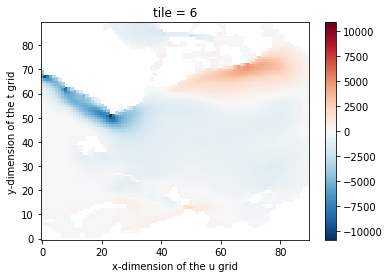

In [30]:
SIu_transport.mean('time')[6].where(main.hFacW[0,6].values==1).plot()

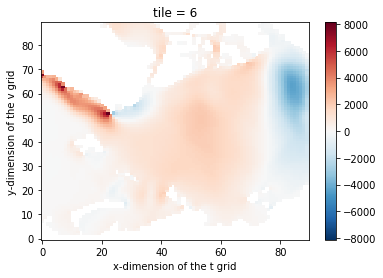

In [31]:
SIv_transport.mean('time')[6].where(main.hFacS[0,6].values==1).plot()

In [32]:
# Sea ice freshwater fluxes through strait (m^3/s)
sec_trsp_x = (SIu_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (SIv_transport * maskS).sum(dim=['i','j_g','tile'])

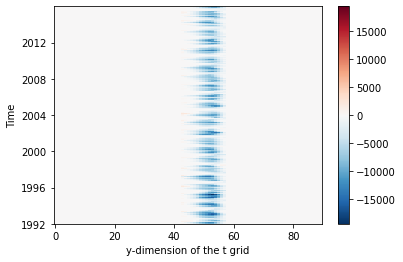

In [33]:
(SIu_transport * maskW).sum(dim=['i_g','tile']).plot()

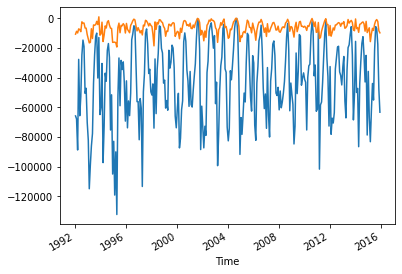

In [34]:
sec_trsp_x.plot()
sec_trsp_y.plot()

In [35]:
# Sea ice freshwater transport (Sv)
sec_SItrsp = (sec_trsp_x + sec_trsp_y).compute()*Sv

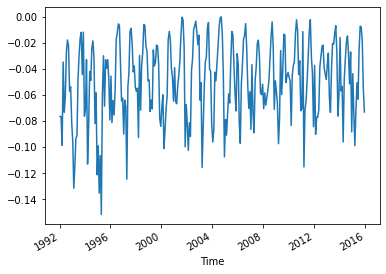

In [36]:
sec_SItrsp.plot()

In [37]:
print('Sea ice FW flux (Sref =',Sref, '/ Sice =',Sice,'/ 1992-2015):', 
      np.round(sec_SItrsp.mean('time').values*1e3,1),'±',np.round(2*sec_SItrsp.std('time').values*1e3,1),'mSv')

Sea ice FW flux (Sref = 34.9 / Sice = 4.0 / 1992-2015): -49.4 ± 59.4 mSv


Sea ice FW flux (Sref = 35.0 / Sice = 4.0 / 1992-2015): -49.4 ± 59.4 mSv


### Compare volume, freshwater and sea ice flux through Fram Strait

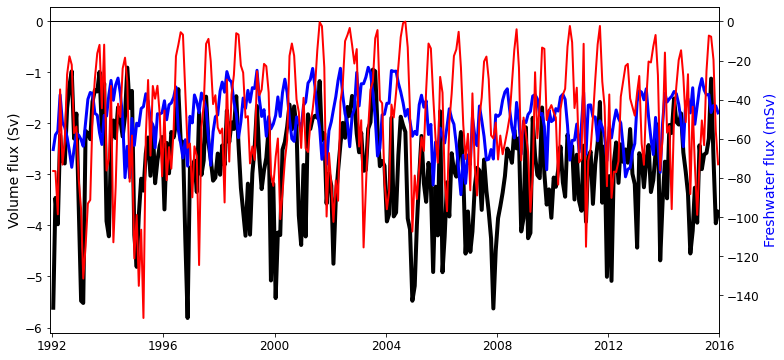

In [38]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(sec_trsp.time, sec_trsp, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(sec_FWtrsp.time, sec_FWtrsp*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(sec_SItrsp.time, sec_SItrsp*1e3, lw=2, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
#ax2.set_ylim([-1200,1200])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='b', fontsize=14)

plt.show()

In [39]:
df = sec_trsp.reset_coords(drop=True).to_dataframe(name='vol')
df['liquid'] = sec_FWtrsp.reset_coords(drop=True).to_dataframe(name='liquid')
df['sea_ice'] = sec_SItrsp.reset_coords(drop=True).to_dataframe(name='sea_ice')

In [40]:
df.corr()

,vol,liquid,sea_ice
vol,1.000000,0.230963,0.481412
liquid,0.230963,1.000000,-0.081460
sea_ice,0.481412,-0.081460,1.000000


In [41]:
# Annual means
df_1yr = df.resample('1A',kind='timestamp',loffset='-6M').mean()

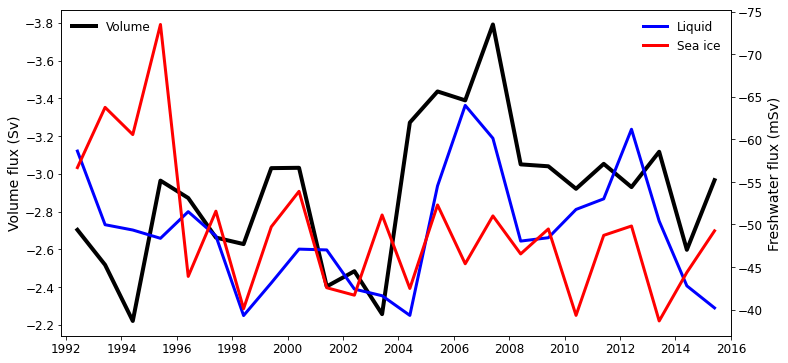

In [44]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.plot(df_1yr.index, df_1yr.vol, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux (Sv)', color='k',fontsize=14)
ax1.invert_yaxis()
ax1.legend(loc='upper left',frameon=False,fontsize=12)

ax2 = ax1.twinx()
ax2.plot(df_1yr.index, df_1yr.liquid*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(df_1yr.index, df_1yr.sea_ice*1e3, lw=3, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

#ax2.set_ylim([-1200,1200])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux (mSv)', color='k', fontsize=14)
ax2.invert_yaxis()
ax2.legend(loc='upper right',frameon=False,fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

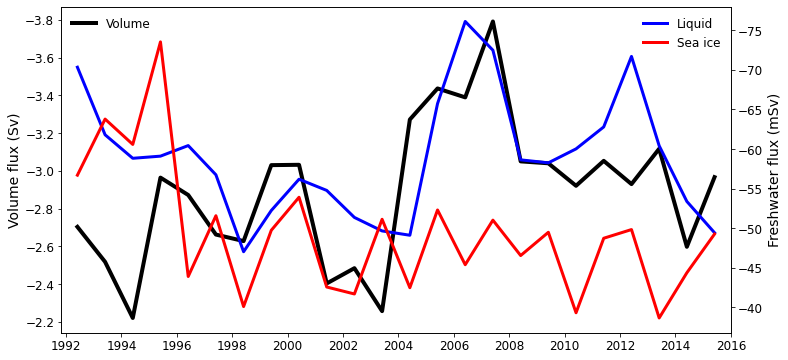

In [45]:
df_1yr

,vol,liquid,sea_ice
time,,,
1992-06-30,-2.702751,-0.058613,-0.056673
1993-06-30,-2.517145,-0.049966,-0.063747
1994-06-30,-2.219801,-0.049343,-0.060550
1995-06-30,-2.963658,-0.048368,-0.073482
1996-06-30,-2.871523,-0.051499,-0.043895
1997-06-30,-2.661881,-0.048643,-0.051555
1998-06-30,-2.627297,-0.039296,-0.040102
1999-06-30,-3.029830,-0.043128,-0.049719
2000-06-30,-3.031574,-0.047100,-0.053888


In [92]:
df_1yr.corr()

,vol,liquid,sea_ice
vol,1.000000,0.481994,-0.108291
liquid,0.481994,1.000000,0.221068
sea_ice,-0.108291,0.221068,1.000000


In [49]:
Vtrsp_anom = sec_trsp.groupby('time.month') - sec_trsp.groupby('time.month').mean('time')
FWtrsp_anom = sec_FWtrsp.groupby('time.month') - sec_FWtrsp.groupby('time.month').mean('time')
SItrsp_anom = sec_SItrsp.groupby('time.month') - sec_SItrsp.groupby('time.month').mean('time')

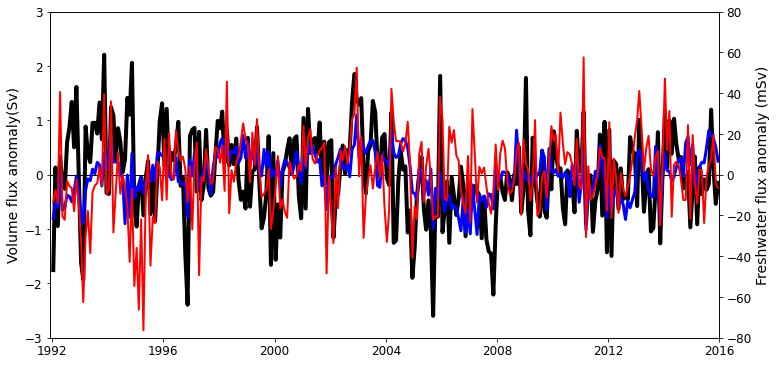

In [51]:
fig, ax1 = plt.subplots(figsize=(12,6))

ax1.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax1.plot(Vtrsp_anom.time, Vtrsp_anom, lw=4, color='k',label='Volume')
ax1.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax1.set_ylim([-3,3])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Volume flux anomaly(Sv)', color='k',fontsize=14)

ax2 = ax1.twinx()
ax2.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax2.plot(FWtrsp_anom.time, FWtrsp_anom*1e3, lw=3, color='blue',linestyle='-',label='Liquid')
ax2.plot(SItrsp_anom.time, SItrsp_anom*1e3, lw=2, color='r',linestyle='-',label='Sea ice')
ax2.set_xlim([datetime.date(1991, 12, 1), datetime.date(2016, 1, 1)])
ax2.set_ylim([-80,80])
ax2.tick_params(axis='both',labelsize=12)
ax2.set_ylabel(r'Freshwater flux anomaly (mSv)', color='k', fontsize=14)

plt.show()

### Compare sea ice flux through Fram Strait with sea ice flux within Nordic Seas

In [15]:
oceFW = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw_oceFW.nc')

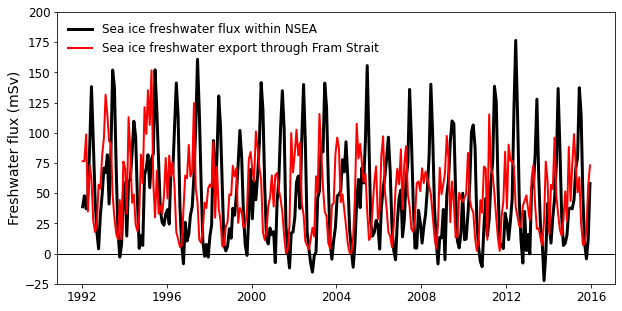

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW.time, oceFW.sel(region='nsea',term='forcFwSI').fw*1e3, lw=3, color='black',
        label='Sea ice freshwater flux within NSEA')
ax.plot(sec_SItrsp.time, -sec_SItrsp*1e3, lw=2, color='r',linestyle='-',
        label='Sea ice freshwater export through Fram Strait')
ax.set_ylim([-25,200])
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux (mSv)',fontsize=14)
ax.legend(loc='upper left',frameon=False,fontsize=12)

plt.show()

#### Flux anomalies

In [17]:
oceFW_anom = oceFW.groupby('time.month') - oceFW.groupby('time.month').mean('time')
SItrsp_anom = sec_SItrsp.groupby('time.month') - sec_SItrsp.groupby('time.month').mean('time')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


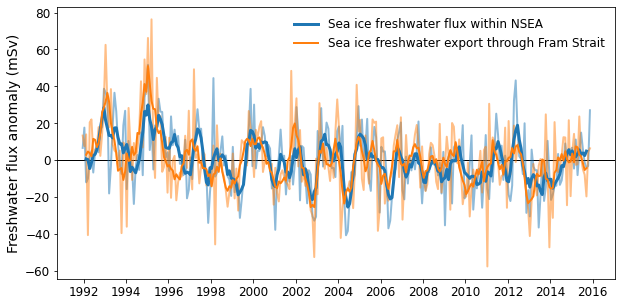

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='nsea',term='forcFwSI').fw*1e3, lw=2,alpha=0.5,label=None)
ax.plot(SItrsp_anom.time, -SItrsp_anom*1e3, lw=2,linestyle='-',alpha=0.5,label=None)
ax.plot(oceFW_anom.time, oceFW_anom.sel(region='nsea',term='forcFwSI').fw.rolling(time=5, center=True).mean()*1e3, 
        lw=3,color='tab:blue',label='Sea ice freshwater flux within NSEA')
ax.plot(SItrsp_anom.time, -SItrsp_anom.rolling(time=5, center=True).mean()*1e3, lw=2,linestyle='-',color='tab:orange',
        label='Sea ice freshwater export through Fram Strait')


#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater flux anomaly (mSv)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [145]:
df = oceFW_anom.sel(region='nsea',term='forcFwSI').fw.reset_coords(drop=True).to_dataframe(name='SI_flux')
df['FrS_export'] = -SItrsp_anom.reset_coords(drop=True).to_dataframe(name='FrS_export')

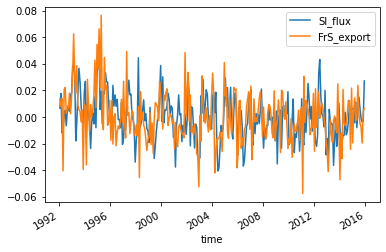

In [146]:
df.plot()

In [147]:
df.corr()

,SI_flux,FrS_export
SI_flux,1.000000,0.422297
FrS_export,0.422297,1.000000


In [126]:
import seaborn as sns

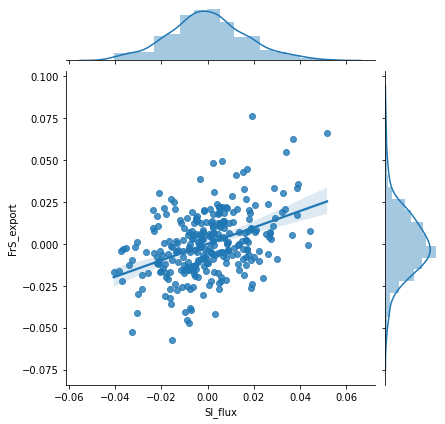

In [127]:
sns.jointplot(x="SI_flux", y="FrS_export", data=df, kind="reg")

In [141]:
# Annual means
df['dt'] = main.reset_coords().dt.sel(time=slice('1992-02-01','2015-11-30')).to_dataframe().dt
df_sub = df.loc[(df.index > '1992-12-31')&(df.index < '2015-01-01')]
df_1yr = df_sub.multiply(df_sub["dt"], axis="index").resample('1A',kind='period').sum().drop(columns=['dt'])

In [143]:
df_1yr.corr()

,SI_flux,FrS_export
SI_flux,1.000000,0.865319
FrS_export,0.865319,1.000000


In [149]:
from scipy import stats

In [155]:
stats.pearsonr(df_1yr.SI_flux,df_1yr.FrS_export)

(0.8653188833274439, 2.0091453157633963e-07)

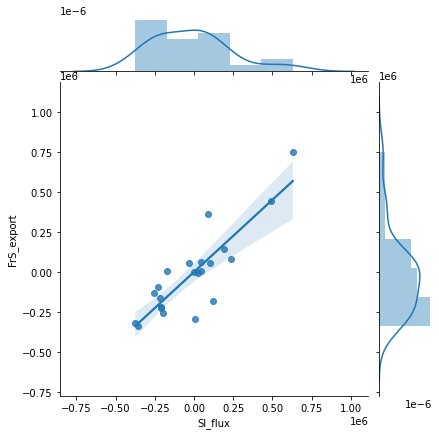

In [148]:
sns.jointplot(x="SI_flux", y="FrS_export", data=df_1yr, kind="reg")

In [109]:
oceFW_int = (oceFW_anom.isel(time=slice(1, -1)).fw*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')
SItrsp_int = (SItrsp_anom.isel(time=slice(1, -1))*main.isel(time=slice(1, -1)).dt).cumsum(dim='time')


oceFW_int_anom = oceFW_int - oceFW_int.mean('time')
SItrsp_int_anom = SItrsp_int - SItrsp_int.mean('time')

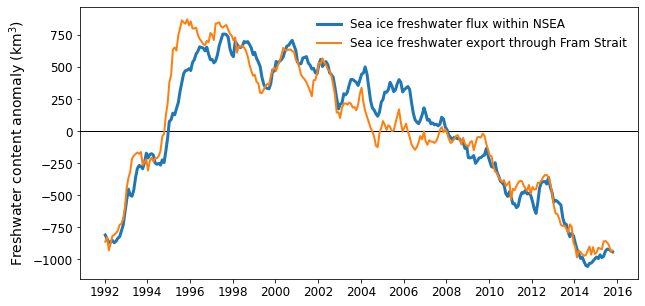

In [113]:
fig, ax = plt.subplots(figsize=(10,5))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(oceFW_int_anom.time, oceFW_int_anom.sel(region='nsea',term='forcFwSI')*1e-3, lw=3,
        label='Sea ice freshwater flux within NSEA')
ax.plot(SItrsp_int_anom.time, -SItrsp_int_anom*1e-3, lw=2, linestyle='-',
        label='Sea ice freshwater export through Fram Strait')
#ax.set_ylim([-25,200])
ax.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Freshwater content anomaly (km$^3$)',fontsize=14)
ax.legend(loc='upper right',frameon=False,fontsize=12)

plt.show()